In [1]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras import losses
from PIL import Image
import numpy as np
import argparse
import os

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.externals import joblib
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm
from sklearn.metrics import r2_score

/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
activation = 'elu'

In [3]:
class CustomLoss:
    def __init__(self, _loss_function):
        super(CustomLoss, self).__init__()
        self.loss_function_array = _loss_function.split(',')

    def tf_diff_axis_1(self, a):
        return a[:, 1:] - a[:, :-1]

    def tf_minmax_axis_1(self, a):
        b = self.tf_diff_axis_1(a)
        sign = K.sign(b)
        abs_sign = tf.abs(self.tf_diff_axis_1(sign))
        mask_array = K.greater(abs_sign, 0)

        result = tf.where(mask_array, a[:, 1:-1], tf.zeros_like(a[:, 1:-1]))

        return result

    def custom_loss(self, y_true, y_pred):
        loss = 0
        y_true_diff = self.tf_diff_axis_1(y_true)
        y_pred_diff = self.tf_diff_axis_1(y_pred)
        threshold_value = 0
        y_true_diff_binary = K.cast(K.greater(y_true_diff, threshold_value), K.floatx())
        y_pred_diff_binary = K.cast(K.greater(y_pred_diff, threshold_value), K.floatx())
        y_true_minmax = self.tf_minmax_axis_1(y_true)
        y_pred_minmax = self.tf_minmax_axis_1(y_pred)

        if 'mse' in self.loss_function_array:
            loss = loss + K.mean(K.square(y_pred - y_true))

        if 'diff_mse' in self.loss_function_array:
            loss = loss + K.mean(K.square(y_pred_diff - y_true_diff))

        if 'rmse' in self.loss_function_array:
            loss = loss + K.sqrt(K.mean(K.square(y_pred - y_true)))

        if 'diff_rmse' in self.loss_function_array:
            loss = loss + K.sqrt(K.mean(K.square(y_pred_diff - y_true_diff)))

        if 'diff_ce' in self.loss_function_array:
            loss = loss + losses.binary_crossentropy(y_true_diff, y_pred_diff)

        if 'diff_bce' in self.loss_function_array:
            loss = loss + losses.binary_crossentropy(y_true_diff_binary, y_pred_diff_binary)

        if 'diff_rmse_minmax' in self.loss_function_array:
            loss = loss + K.sqrt(K.mean(K.square(y_pred_minmax - y_true_minmax)))

        if 'diff_poly' in self.loss_function_array:
            x = np.arange(24)
            loss = loss + np.sum(
                (np.polyval(np.polyfit(x, y_pred, 3)) - np.polyval(np.polyfit(x, y_true, 3))) ** 2
            )

        return loss


In [4]:
def tic():
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        runningTime = time.time() - startTime_for_tictoc
        toc_ = "Elapsed time is " + str(runningTime) + " seconds."
        print(toc_)
        return runningTime
    else:
        toc_ = "Toc: start time not set"
        print(toc_)
        return toc_

def scale(arr, std, mean):
    arr -= mean
    arr /= (std + 1e-7)
    return arr


def rescale(arr, std, mean):
    arr = arr * std
    arr = arr + mean

    return arr


def compress_image(prev_image, n):
    height = prev_image.shape[0] // n
    width = prev_image.shape[1] // n
    new_image = np.zeros((height, width), dtype="uint8")
    for i in range(0, height):
        for j in range(0, width):
            new_image[i, j] = prev_image[n * i, n * j]
    return new_image


In [5]:
def create_model(model_type, model_input_shape, loss_function):
    if model_type.startswith('cnn'):
        model = Sequential()
        model.add(Conv2D(16, kernel_size=(3, 3), padding='same', input_shape=model_input_shape, use_bias=False))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(32, kernel_size=(3, 3), padding='same', use_bias=False))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(32, kernel_size=(3, 3), padding='same', use_bias=False))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(32, kernel_size=(3, 3), padding='same', use_bias=False))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dense(1024, activation='relu'))
        model.add(Dropout(0.4))
        model.add(Dense(24, activation=activation))
        model.compile(loss=loss_function, optimizer=Adam(lr=0.0005), metrics=['accuracy'])
    elif model_type.startswith('rf'):
        regr = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=2)
        return regr
    elif model_type.startswith('svm'):
        regr = SVR(kernel='rbf', C=1e3, gamma=0.1)
        return regr
    elif model_type.startswith('lasso'):
        regr = Lasso()
        return regr
    elif model_type.startswith('lr'):
        regr = LinearRegression()
        return regr
    elif model_type.startswith('ridge'):
        regr = Ridge()
        return regr
    elif model_type.startswith('mlp'):
        regr = MLPRegressor(solver='lbfgs', alpha=1e-5,
                            hidden_layer_sizes=(20, 10), random_state=1)
        return regr
    elif model_type.startswith('knn'):
        regr = KNeighborsRegressor()
        return regr
    elif model_type.startswith('elasticnet'):
        regr = ElasticNet(random_state=0)
        return regr
    elif model_type.startswith('extratree'):
        regr = ExtraTreesRegressor(n_estimators=10,
                                   max_features=32,  # Out of 20000
                                   random_state=0)
        return regr
    elif model_type.startswith('dt'):
        regr = DecisionTreeRegressor(max_depth=5)
        return regr
    elif model_type.startswith('gbr'):
        regr = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100, max_depth=5))
        return regr
    elif model_type.startswith('ada'):
        regr = MultiOutputRegressor(AdaBoostRegressor(n_estimators=300))
        return regr
    else:
        model = Sequential()
        model.add(Dense(512, activation='relu', input_dim=model_input_shape))
        model.add(Dense(512, activation='relu'))
        model.add(Dense(24, activation='sigmoid'))
        model.compile(loss=loss_function, optimizer='adam', metrics=['accuracy'])

    return model

In [6]:
## TRAIN
DATAPATH_TRAIN = os.path.join('data', 'train')
DATASETS_TRAIN = [
    'binary_501',
    'binary_502',
    'binary_503',
    'binary_504',
    'binary_505',
    'binary_506',
    'binary_507',
    'binary_508',
    'binary_509',
    'binary_510',
    'binary_511',
    'binary_512',
    'binary_1001',
    'binary_1002',
    'binary_1003',
    'binary_rl_fix_501',
    'binary_rl_fix_502',
    'binary_rl_fix_503',
    'binary_rl_fix_504',
    'binary_rl_fix_505',
    'binary_rl_fix_506',
    'binary_rl_fix_507',
    'binary_rl_fix_508',
    'binary_rl_fix_509',
    'binary_rl_fix_510',
    'binary_rl_fix_511',
    'binary_rl_fix_512',
    'binary_rl_fix_513',
    'binary_rl_fix_514',
    'binary_rl_fix_515',
    'binary_rl_fix_516',
    'binary_rl_fix_517',
    'binary_rl_fix_518',
    'binary_rl_fix_519',
    'binary_rl_fix_520',
    'binary_rl_fix_1001',
    'binary_rl_fix_1002',
    'binary_rl_fix_1003',
    'binary_rl_fix_1004',
    'binary_rl_fix_1005',
    'binary_rl_fix_1006',
    'binary_rl_fix_1007',
    'binary_rl_fix_1008',
]

## VALIDATION
DATAPATH_VALID = './data/valid'
DATASETS_VALID = [
    'binary_1004',
    'binary_test_1001',
    'binary_test_1002',
    'binary_rl_fix_1009',
    'binary_rl_fix_1010',
    'binary_rl_fix_1011',
    'binary_rl_fix_1012',
    'binary_rl_fix_1013',
    'binary_rl_fix_test_1001',
]

## TEST
DATAPATH_TEST = './data/test'
DATASETS_TEST = [
    'binary_new_test_501',
    'binary_new_test_1501',
    'binary_rl_fix_1014',
    'binary_rl_fix_1015',
    'binary_rl_fix_test_1002',
    'binary_rl_fix_test_1003',
    'binary_rl_fix_test_1004',
    'binary_rl_fix_test_1005',
    'binary_test_1101',
]


In [7]:
parser = argparse.ArgumentParser()
parser.add_argument("-m", "--model", help="Select model type.", default="cnn")
parser.add_argument("-s", "--shape", help="Select input image shape. (rectangle or square?)", default='rect')
parser.add_argument("-l", "--loss_function", help="Select loss functions.. (rmse,diff_rmse,diff_ce)",
                    default='rmse')
parser.add_argument("-e", "--epochs", help="Set epochs", default=300)
parser.add_argument("-b", "--batch_size", help="Set batch size", default=128)
parser.add_argument("-n", "--is_normalized", help="Set is Normalized", action='store_true')
parser.add_argument("-d", "--data_type", help="Select data type.. (train, valid, test)",
                    default='train')

_StoreAction(option_strings=['-d', '--data_type'], dest='data_type', nargs=None, const=None, default='train', type=None, choices=None, help='Select data type.. (train, valid, test)', metavar=None)

In [8]:
args = parser.parse_args(args=[])
model_name = args.model
batch_size = int(args.batch_size)
epochs = int(args.epochs)
loss_functions = args.loss_function
input_shape_type = args.shape

In [9]:
# epochs = 5

In [10]:
DATAPATH = DATAPATH_TRAIN
DATASETS = DATASETS_TRAIN

In [11]:
if input_shape_type.startswith('rect'):
    img_rows, img_cols, channels = 100, 200, 1
else:
    img_rows, img_cols, channels = 200, 200, 1

if model_name.startswith('cnn') is False and model_name.startswith('nn') is False:
    img_rows = img_rows // 10
    img_cols = img_cols // 10

x_train = []
y_train = []

In [12]:
print('Data Loading... Train dataset Start.')

# load Train dataset
for data in tqdm(DATASETS):
    dataframe = pd.read_csv(os.path.join(DATAPATH, '{}.csv'.format(data)), delim_whitespace=False, header=None)
    dataset = dataframe.values

    # split into input (X) and output (Y) variables
    fileNames = dataset[:, 0]
    y_train.extend(dataset[:, 1:25])
    for idx, file in enumerate(fileNames):

        try:
            image = Image.open(os.path.join(DATAPATH, data, '{}.tiff'.format(int(file))))
            image = np.array(image, dtype=np.uint8)
        except (TypeError, FileNotFoundError) as te:
            image = Image.open(os.path.join(DATAPATH, data, '{}.tiff'.format(idx + 1)))
            try:
                image = np.array(image, dtype=np.uint8)
            except:
                continue

        if model_name.startswith('cnn') is False and model_name.startswith('nn') is False:
            image = compress_image(image, 10)

        if model_name.startswith('cnn_small'):
            image = compress_image(image, 5)

        if input_shape_type.startswith('rect'):
            x_train.append(image)
        else:
            v_flipped_image = np.flip(image, 0)
            square_image = np.vstack([image, v_flipped_image])
            x_train.append(square_image)

print('Data Loading... Train dataset Finished.')

  2%|▏         | 1/43 [00:00<00:05,  8.29it/s]

Data Loading... Train dataset Start.


100%|██████████| 43/43 [00:08<00:00,  4.87it/s]

Data Loading... Train dataset Finished.


In [13]:
print('Data Loading... Validation dataset Start.')

DATAPATH = DATAPATH_VALID
DATASETS = DATASETS_VALID

x_validation = []
y_validation = []
for data in tqdm(DATASETS):
    dataframe = pd.read_csv(os.path.join(DATAPATH, '{}.csv'.format(data)), delim_whitespace=False, header=None)
    dataset = dataframe.values

    # split into input (X) and output (Y) variables
    fileNames = dataset[:, 0]
    y_validation.extend(dataset[:, 1:25])
    for idx, file in enumerate(fileNames):

        try:
            image = Image.open(os.path.join(DATAPATH, data, '{}.tiff'.format(int(file))))
            image = np.array(image, dtype=np.uint8)
        except (TypeError, FileNotFoundError) as te:
            image = Image.open(os.path.join(DATAPATH, data, '{}.tiff'.format(idx + 1)))
            try:
                image = np.array(image, dtype=np.uint8)
            except:
                continue

        if model_name.startswith('cnn') is False and model_name.startswith('nn') is False:
            image = compress_image(image, 10)

        if model_name.startswith('cnn_small'):
            image = compress_image(image, 5)

        if input_shape_type.startswith('rect'):
            x_validation.append(image)
        else:
            v_flipped_image = np.flip(image, 0)
            square_image = np.vstack([image, v_flipped_image])
            x_validation.append(square_image)

print('Data Loading... Validation dataset Finished.')


  0%|          | 0/9 [00:00<?, ?it/s]

Data Loading... Validation dataset Start.


100%|██████████| 9/9 [00:03<00:00,  2.81it/s]

Data Loading... Validation dataset Finished.


In [14]:

x_train = np.array(x_train)
y_train = np.array(y_train)
y_train = np.true_divide(y_train, 2767.1)

x_validation = np.array(x_validation)
y_validation = np.array(y_validation)
y_validation = np.true_divide(y_validation, 2767.1)

if args.is_normalized:
    print('y_train mean : ', y_train.mean(), np.std(y_train))
    MEAN = 0.5052
    STD = 0.2104
    y_train = scale(y_train, MEAN, STD)
    y_validaton = scale(y_validation, MEAN, STD)

if model_name.startswith('cnn'):
    if K.image_data_format() == 'channels_first':
        x_train = x_train.reshape(x_train.shape[0], channels, img_rows, img_cols)
        y_train = y_train.reshape(y_train.shape[0], channels, img_rows, img_cols)

        x_validation = x_validation.reshape(x_validation.shape[0], channels, img_rows, img_cols)
        y_validation = y_validation.reshape(y_validation.shape[0], channels, img_rows, img_cols)
        input_shape = (channels, img_rows, img_cols)
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
        x_validation = x_validation.reshape(x_validation.shape[0], img_rows, img_cols, channels)
        input_shape = (img_rows, img_cols, channels)
else:
    if K.image_data_format() == 'channels_first':
        x_train = x_train.reshape(x_train.shape[0], channels * img_rows * img_cols)
        y_train = y_train.reshape(y_train.shape[0], channels * img_rows * img_cols)
        x_validation = x_validation.reshape(x_validation.shape[0], channels * img_rows * img_cols)
        y_validation = y_validation.reshape(y_validation.shape[0], channels * img_rows * img_cols)
        input_shape = channels * img_rows * img_cols
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows * img_cols * channels)
        x_validation = x_validation.reshape(x_validation.shape[0], img_rows * img_cols * channels)
        input_shape = channels * img_rows * img_cols

# for DEBUG
# print('x shape:', x_train.shape)
# print('y shape:', y_train.shape)
# print(x_train.shape[0], 'train samples')

In [15]:
custom_loss = CustomLoss(loss_functions)
model = create_model(model_name, input_shape, custom_loss.custom_loss)

tic()
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    # pass validtation for monitoring
                    # validation loss and metrics
                    validation_data=(x_validation, y_validation))
toc()

Epoch 1/300
211/211 [==============================] - 3s 16ms/step - loss: 0.1455 - accuracy: 0.1347 - val_loss: 0.0902 - val_accuracy: 0.1807
Epoch 2/300
211/211 [==============================] - 3s 15ms/step - loss: 0.1061 - accuracy: 0.1791 - val_loss: 0.0801 - val_accuracy: 0.2249
Epoch 3/300
211/211 [==============================] - 3s 15ms/step - loss: 0.0980 - accuracy: 0.1931 - val_loss: 0.0761 - val_accuracy: 0.2390
Epoch 4/300
211/211 [==============================] - 3s 15ms/step - loss: 0.0940 - accuracy: 0.2093 - val_loss: 0.0727 - val_accuracy: 0.2534
Epoch 5/300
211/211 [==============================] - 3s 15ms/step - loss: 0.0921 - accuracy: 0.2124 - val_loss: 0.0712 - val_accuracy: 0.2684
Epoch 6/300
211/211 [==============================] - 3s 15ms/step - loss: 0.0898 - accuracy: 0.2234 - val_loss: 0.0776 - val_accuracy: 0.2687
Epoch 7/300
211/211 [==============================] - 3s 15ms/step - loss: 0.0881 - accuracy: 0.2332 - val_loss: 0.0695 - val_accuracy:

982.9841849803925

In [16]:
r2_score(model.predict(x_validation), y_validation)

0.8304582645634393

In [17]:
y_train

array([[0.04554226, 0.13161794, 0.19970727, ..., 0.50869141, 0.4630841 ,
        0.43334177],
       [0.02387373, 0.05302663, 0.08701167, ..., 0.16515124, 0.15117632,
        0.14401359],
       [0.08229554, 0.28669726, 0.36861696, ..., 0.64594702, 0.62050522,
        0.60189368],
       ...,
       [0.11900184, 0.24443641, 0.41585053, ..., 0.70286582, 0.70835893,
        0.71002132],
       [0.1400889 , 0.29418886, 0.31678291, ..., 0.67493043, 0.67091901,
        0.65100647],
       [0.05870406, 0.17402335, 0.18622023, ..., 0.49969282, 0.46228904,
        0.44382205]])

In [18]:
GPR = GaussianProcessRegressor()
GPR.fit(model.predict(x_train), y_train)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [19]:
GPR.score(model.predict(x_validation), y_validation)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.7291968004355268

In [20]:
GPR.predict(model.predict(x_validation))

array([[0.13799512, 0.24049854, 0.27672076, ..., 0.69531256, 0.68968546,
        0.68625379],
       [0.07714093, 0.22534847, 0.26344371, ..., 0.58214211, 0.57711148,
        0.57322097],
       [0.07667208, 0.20028722, 0.3048892 , ..., 0.66256994, 0.62811518,
        0.60188019],
       ...,
       [0.20464897, 0.35903203, 0.49649644, ..., 0.80287451, 0.79860353,
        0.79136992],
       [0.10273278, 0.22671139, 0.35660434, ..., 0.58054662, 0.58338797,
        0.57260323],
       [0.17588353, 0.22008109, 0.32180977, ..., 0.62356079, 0.62931049,
        0.62598681]])

In [21]:
(model.predict(x_validation).shape, y_validation.shape)

((9000, 24), (9000, 24))

In [22]:
f'./models/GPR_{epochs}_{activation}.pkl'

'./models/GPR_300_elu.pkl'

In [23]:
joblib.dump(GPR, f'./models/GPR_{epochs}_{activation}.pkl') 

['./models/GPR_300_elu.pkl']

Train loss: 0.029757313430309296
Train accuracy: 0.5111481547355652
accuracy: 51.11%
Saved model to disk


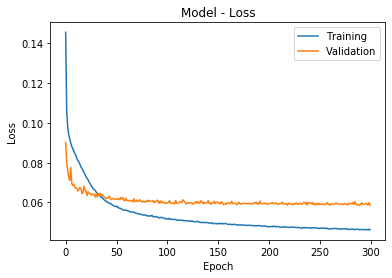

In [24]:
score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
print("%s: %.2f%%" % (model.metrics_names[1], score[1] * 100))

# serialize model to JSON
model_json = model.to_json()
model_export_path_folder = 'models/{}_{}_{}_{}'.format(model_name, batch_size, epochs, activation)
if not os.path.exists(model_export_path_folder):
    os.makedirs(model_export_path_folder)

model_export_path_template = '{}/{}_{}_1.{}'
model_export_path = model_export_path_template.format(model_export_path_folder, loss_functions,
                                                        input_shape_type, 'json')
with open(model_export_path, "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights(
    model_export_path_template.format(model_export_path_folder, loss_functions, input_shape_type, 'h5'))
print("Saved model to disk")

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model - Loss')
plt.legend(['Training', 'Validation'], loc='upper right')
train_progress_figure_path_folder = 'result/train_progress'
if not os.path.exists(train_progress_figure_path_folder):
    os.makedirs(train_progress_figure_path_folder)
plt.savefig('{}/{}_{}.png'.format(train_progress_figure_path_folder, model_name, loss_functions))
